In [ ]:
from functools import lru_cache
import torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

from so_rigidreg.libs.torch_fm.torch_fouriermellin.transform import RigidTransform


image = torchvision.io.read_image('public/mandrill.png')/255.
N=20
bimage = image.unsqueeze(0).expand(N,-1,-1,-1)
gtScale = torch.rand(N)+0.55
gtAngle = torch.randint(-90, 90, (N,)).float()
gtTransX = 75*(torch.rand(N)*2-1)
gtTransY = 75*(torch.rand(N)*2-1)
bimageTransf = RigidTransform(gtScale, gtTransX, gtTransY, gtAngle)(bimage)

In [ ]:
from so_rigidreg.libs.torch_fm.torch_fouriermellin.registration import MellinFourierRegistration


mf = MellinFourierRegistration(*bimage.shape[-2:])
ans = mf.register_image(bimage, bimageTransf)
imageTransfRegistered = ans['registered']


In [48]:
randomRotScale

tensor([[ 3.4000e+01,  1.2261e+01],
        [ 1.5000e+01,  3.1245e+00],
        [-8.7000e+01,  6.2863e-02],
        [-2.8000e+01,  7.8950e-02],
        [ 3.6000e+01,  4.9667e-01],
        [ 6.1000e+01,  2.2564e+00],
        [-2.7000e+01,  9.6797e-01],
        [ 6.5000e+01,  1.7256e+01],
        [-1.8000e+01,  1.0590e+01],
        [-3.0000e+00,  1.5639e-01],
        [-2.3000e+01,  4.4319e-01],
        [ 4.1000e+01,  3.3347e+00],
        [ 4.0000e+00,  1.6169e+01],
        [ 4.3000e+01,  4.5431e+00],
        [ 3.0000e+00,  5.9404e-01],
        [ 4.2000e+01,  1.7676e+00],
        [-6.5000e+01,  1.3290e-01],
        [-3.9000e+01,  9.5978e-02],
        [ 1.1000e+01,  2.3310e+00],
        [ 4.7000e+01,  9.2185e-01]])

In [43]:
pcRotScaleTruth.shape

torch.Size([20, 180, 362])

In [32]:
randomRotIdx.shape,rotScaleGrid[0].unsqueeze(0).shape

(torch.Size([20]), torch.Size([1, 180, 362]))

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [10]:
mf.get_parameters_domain()

{'tyRange': torch.return_types.aminmax(
 min=tensor(-256),
 max=tensor(255)),
 'txRange': torch.return_types.aminmax(
 min=tensor(-256),
 max=tensor(255)),
 'rotRange': torch.return_types.aminmax(
 min=tensor(-89.),
 max=tensor(90.)),
 'scaleRange': torch.return_types.aminmax(
 min=tensor(0.0534),
 max=tensor(19.0263))}

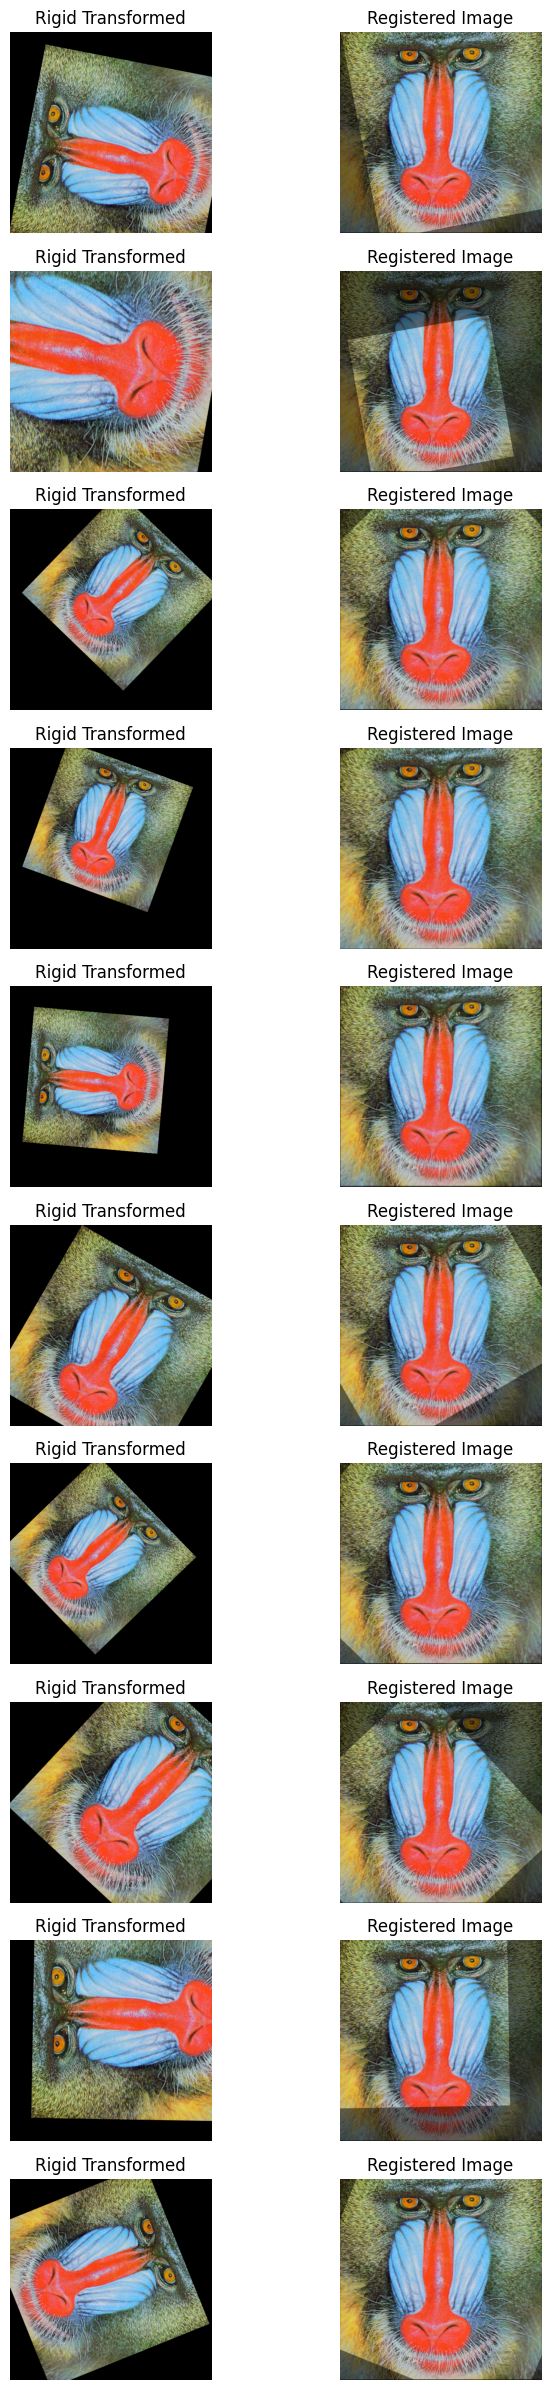

In [5]:

fig, axs = plt.subplots(10, 2, figsize=(8, 24))
for i in range(10):
    axs[i, 0].imshow(bimageTransf[i].moveaxis(0,-1))
    axs[i, 0].set_title('Rigid Transformed')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(imageTransfRegistered[i].moveaxis(0,-1))
    axs[i, 1].set_title('Registered Image')
    axs[i, 1].imshow(bimage[i].moveaxis(0,-1), alpha=0.5)
    axs[i, 1].axis('off')
plt.tight_layout()
plt.show()

In [6]:
qsdqsd

NameError: name 'qsdqsd' is not defined

In [ ]:
plt.imshow(LogPolarRepresentation(*bimage.shape[-2:]).cart2pol(
        bimage
)[0].mean(0))

In [ ]:
plt.imshow(
        bimageTransf
[6].mean(0))

In [ ]:
plt.imshow(LogPolarRepresentation(*bimage.shape[-2:]).cart2pol(
        bimageTransf
)[6].mean(0))

In [ ]:
plt.imshow(LogPolarRepresentation(*bimage.shape[-2:]).pol2cart(LogPolarRepresentation(*bimage.shape[-2:]).cart2pol(
        bimage
))[6].mean(0))
plt.colorbar()
plt.imshow(bimage[6].mean(0), alpha=0.5)

In [ ]:
hp_filt = HighPassFilter()
logpol = LogPolarRepresentation(*bimage.shape[-2:])

bimageFft = fft2d(bimage)
bimageTransfFft = fft2d(bimageTransf)
bimageFftAbs = hp_filt(bimageFft)
bimageFftTransfAbs =  hp_filt(bimageTransfFft)

In [ ]:
bimageLogPolMag = logpol.cart2pol(bimageFftAbs)
bimageTransfLogPolMag = logpol.cart2pol(bimageFftTransfAbs)

In [ ]:
plt.imshow(bimageLogPolMag[6].mean(0))

In [ ]:
bimageLogPolMag.shape

In [ ]:
pc = PhaseCorrelation()(bimageLogPolMag[...,:180,:],bimageTransfLogPolMag[...,:180,:]).sum(-3)

plt.imshow(pc.abs()[0])

In [ ]:
topPc = pc.abs().flatten(-2).topk(1, dim=(-1))
predsRotsScale = torch.stack(torch.unravel_index(topPc.indices, pc.shape[-2:]), -2)
estRot = -predsRotsScale[:,0,0] + 90
radius = (torch.norm(torch.tensor(bimage.shape[-2:], dtype=torch.float32))/2).long().item()
estScale = (radius ** (-((predsRotsScale[:,1] - pc.size(-1)//2)) / radius))[...,0] 

In [ ]:
(estRot-gtAngle)%180

In [ ]:
scale_loss(estScale,gtScale),rot_loss(estRot, gtAngle)

In [ ]:
bimageUnrotUnscaled = RigidTransform(1/estScale, torch.zeros_like(estScale), torch.zeros_like(estScale), -estRot )(bimageTransf)

In [ ]:
pc_translat = PhaseCorrelation(shift=False)(bimage,bimageUnrotUnscaled)
iMax, jMax =  torch.unravel_index(pc_translat.flatten(-2).sum(-2).argmax(-1), pc_translat.shape[-2:]) 
estTrans = torch.stack([iMax.where(iMax<pc_translat.size(-2)//2, iMax-pc_translat.size(-2)),jMax.where(jMax<pc_translat.size(-1)//2, jMax-pc_translat.size(-1))], dim=-1)
gtTrans = torch.stack([gtTransY, gtTransX], dim=-1)

In [ ]:
gtTrans.long()-estTrans

In [ ]:
gtTrans

In [ ]:
estTransTransf= torch.einsum("bcd, bd -> bc", RigidTransform.rotmat_2d(estRot), estTrans.float())/estScale.unsqueeze(-1)
bimageUntransf= RigidTransform(1/estScale,-estTransTransf[:,1], -estTransTransf[:,0], -estRot)(bimageTransf)
fig, axs = plt.subplots(10, 3, figsize=(8, 24))
for i in range(10):
    axs[i, 0].imshow(bimageTransf[i].mean(0))
    axs[i, 0].set_title('Rigid Transformed')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(bimageUnrotUnscaled[i].mean(0))
    axs[i, 1].set_title('Unrot & Unscaled Image')
    axs[i, 1].axis('off')
    axs[i, 2].imshow(bimageUntransf[i].mean(0))
    axs[i, 2].set_title('Registered Image')
    axs[i, 2].imshow(bimage[i].mean(0), alpha=0.5)
    axs[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
estTrans[:,1]

In [ ]:
estTransTransf